In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
import utils_function
import utils_class

In [ ]:
filename = "/content/drive/MyDrive/ADM/HW5/"
#filename = "/content/drive/MyDrive/HW5/"

# Exercise 1

### READ DATA

In [ ]:
a2q = pd.read_csv(filename + 'sx-stackoverflow-a2q.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
c2a = pd.read_csv(filename + 'sx-stackoverflow-c2a.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
c2q = pd.read_csv(filename + 'sx-stackoverflow-c2q.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)

###Trasform timestamp in date

In [ ]:
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
c2a[2] = pd.to_datetime(c2a[2], unit='s').dt.strftime("%Y%m%d").astype(int)
c2q[2] = pd.to_datetime(c2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)

### Drop edge on themselve

in order not to have cycles on themselves in the graph, and not to have problems walking along the paths, we preferred to drop the nodes that go on themselves

In [ ]:
c2q.drop(c2q[c2q[0] == c2q[1]].index, inplace = True)
c2a.drop(c2a[c2a[0] == c2a[1]].index, inplace = True)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

### Subset of dataset

to get an immediate answer we preferred to take a small subset of data over a period of time, in this case all dataset before 2009

In [ ]:
subset_a2q = a2q[a2q[2] < 20090101].copy()
subset_c2a = c2a[c2a[2] < 20090101].copy()
subset_c2q = c2q[c2q[2] < 20090101].copy()

In [ ]:
users = dict()
users = create_graph(subset_a2q, "a2q", 1, users)
users = create_graph(subset_c2a, "c2a", 2, users)
users = create_graph(subset_c2q, "c2q", 3, users)

In [ ]:
import pickle
with open(filename + 'graph.pickle', 'wb') as fp:
    pickle.dump(users, fp, pickle.HIGHEST_PROTOCOL)

# LOAD DATA FROM FILE

In [ ]:
import pickle
filename = '/content/drive/MyDrive/ADM/HW5/graph.pickle'
with open(filename, 'rb') as handle:
    graph = pickle.load(handle)

# EX 2

In [ ]:
def call_function(name_graph, i):
    if i == 1:
        return get_features(name_graph)

## EX 2.1

In [ ]:
call_function("a2q", 1)

In [ ]:
G = graph_to_networkx(graph, 'all')

In [ ]:
nx.density(G)

0.0004974014377421863

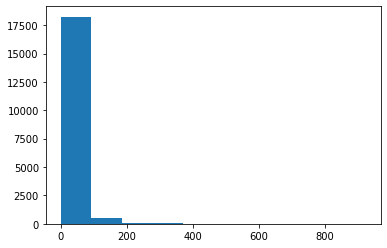

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)
plt.show()

## EX 2.2

In [ ]:
def page_rank(graph, source, start, end):
    start, end = convertDate(start), convertDate(end)
    iterations, d = 100, 0.85
    n = len(graph)
    get_in_degree_user = {user: getDegree(graph[user].get_in_relation, start, end, False)[1] for user in graph}
    get_out_degree_user = {user: getDegree(graph[user].get_out_relation, start, end)[0] for user in graph}
    page_rank = {node: 1/n for node in graph}
    for iteration in range(iterations):
        for user in graph:
            sum = 0
            in_A = get_in_degree_user[user]
            for node in in_A:
                sum += page_rank[node] / get_out_degree_user[node]
            page_rank[user] = (0.15) / n +  d*sum
    return  page_rank

In [ ]:
def degreeCentrality(graph, source, start, end):
    start = convertDate(start)
    end = convertDate(end)
    weight = 0
    g = graph[source].get_out_relation
    for year in g:
        for rel in g[year]:
            for edge in g[year][rel]:
                weight += edge.weight
    return weight/(len(graph)-1)

In [ ]:
def GetCloseness(graph, source, start, end):
    distances = 0
    keys = set(graph.keys())
    keys.remove((source))
    _, cost = myDijkstra(graph, source, start,end)
    cost = np.array(list(cost.values()))
    position = np.where(cost != float('inf'))[0]
    if sum(cost[position]) == 0: return 0
    return round((len(position) - 1) / sum(cost[position]),3)

In [ ]:
from tqdm import tqdm
def BetweennessCentrality(graph, source, start, end):
    st, stv, el = 0, 0, 0
    sum = 0
    for s, t in tqdm(graph.items()):
        if s != source:
            prev, dist, path = dijkstraNumShortesPath(graph, s, start, end)
            for t in graph:
                if  s != t and t != source:
                    if prev[t] != -1:
                        all_path = allShortPath(prev, t, s, [], all_path=[]) 
                        freq = freq_(all_path)
                        if freq == -1 :
                            freq_source = 0
                        else:
                            freq_source = freq.get(source, 0)
                        if t in path:
                            sum += (freq_source) / path.get(t, 0)
    return round(sum / ((len(graph) -2) * (len(graph) - 1)), 3)

In [ ]:
GetCloseness(graph, 3, "08/2008", "01/2009")

## EX 2.3

In [11]:
p_1,p_n = 1, 49
orderedRoute = [17]
start = "08/2008"
end = "12/2008"

with open('graph (1).pickle', 'rb') as handle:
    graph = pickle.load(handle)
    
bestPath, cost = shortestOrderedRoute(graph,start, end,orderedRoute,p_1,p_n)

print("The shortest ordered route between", p_1, "and", p_n,"is:",bestPath, "\nand it costs:", cost)

The shortest ordered route between 1 and 49 is: [1, 49, 17, 49] 
and it costs: 3


## EX 2.4

In [ ]:
def minCut(graph, source, target, start=200808, end=201612):
    res = createResidualG(graph)
    max_flow = 0
    path = dict()

    while BFS(res, source, target, path)[0]:
        bottleneck = getBottleneck(path, source, target)
        max_flow += bottleneck
        updateResGraph(res, path, bottleneck, source, target)
    
    print("Max Flow is:", max_flow)
    reachable = reachFromS(res, source) 
    edges = set()
    capacity = 0
    for v in reachable:
        neighbor = graph[v].get_out_relation
        for year in neighbor:
            for rel in neighbor[year]:
                for i in range(len(neighbor[year][rel])):
                    relX = res[v].get_out_relation[year][rel][i]
                    rely = graph[v].get_out_relation[year][rel][i]

                    if (start <= relX.time <= end) and relX.weight == 0 and relX.target not in reachable and (v, relX.target) not in edges:
                        edges.add((v, relX.target))
                        capacity += rely.weight 
                
    print("Capacity is:", capacity)
    return edges

# 4. Algorithmic question

We need to create an algorithm that given as input a list of k pairs of n kids that may argue, it try to split them in two dormitories.

To test if it was possible to divide the children into two dormitories, we create an auxilary function **assign_dormitory_to_child** which,given as input:
- the current *child*,
- the set of *dormitory_1* and *dormitory_2*, 
- the child with whom he might argue *not_with* 
- the set of the remaining *children*
it outputs whether is possible to *assign* the current *child*, the update of *dormitory_1* and *dormitory_2* and the set of the remaining *children*.

**assign_dormitory_to_child** checks if *child* is already in one of the two dormitories, if not, checks if in *dormitory_1* there is already the child with whom he would figth with (*not_with*), in the positive case add *child* to *dormitory_2*, otherwise try to insert him in *dormitory_1*.

In [1]:
def assign_dormitory_to_child(child, dormitory_1, dormitory_2, not_with, children):
    assign = False
    if child not in dormitory_1 and child not in dormitory_2: #if no dormitory has been assigned to child 
        if not_with in dormitory_1: # if child_2 in dormitory_1, so we put child_1 in dormitory_2
            dormitory_2.add(child)
        else:
            dormitory_1.add(child)
        assign = True
        # updtating the set with the remaining kids
        children.remove(child)
    return assign, dormitory_1, dormitory_2, children

The function **create_pair** receives in input the number of kids *n* and the list of pairs of kids arguing *list_pair*, then we try to create the dormitories by scrolling the list. In case we find two children who cannot stay in the same dormitory we return the state of impossibility in creating the dormitories. 

If we can get all the kids who can fight to the right dormitory, we divide the rest of the children equally between the two dorms.

In [5]:
def create_pair(n, list_pair):
    children = {i for i in range(n)} #set of children to be assigned a dormitory 
    dormitory_1 = set()
    dormitory_2 = set()
    for child_1, child_2 in list_pair:
        # check if (child_1, child_2) it's repeating and the two kids have already been placed in the right dorm 
        if (child_1 in dormitory_1 and child_2 in dormitory_2) or (child_1 in dormitory_2 and child_2 in dormitory_1):
            continue
        else:
            # try to assign dormitory to child_1
            assign_dormitory_child_1, dormitory_1, dormitory_2, children = assign_dormitory_to_child(child_1, dormitory_1, dormitory_2, child_2, children)
            # try to assign dormitory to child_2
            assign_dormitory_child_2, dormitory_1, dormitory_2, children = assign_dormitory_to_child(child_2, dormitory_1, dormitory_2, child_1, children)
            # if both have not been assigned a dormitory 
            if not assign_dormitory_child_1 and not assign_dormitory_child_2: 
                return "It's not possibile to divide the kids in two dormitories."
    # dividing the remaining kids equally
    for i, child in enumerate(children):
        if i % 2 == 0:
            dormitory_1.add(child)
        else:
            dormitory_2.add(child)     
    print("The kid in the first dormitory are:", dormitory_1,"\nThe kid in the second dormitory are:", dormitory_2 )

Lastly we decided to create a random list containing the k pairs, in order to test our algorithm.

In [11]:
# generate random integer values
from random import seed
from random import randint

def dislikes(k,n):
    dislike = []
    # seed random number generator
    seed(124)
    for _ in range(k):
        # generate some integers
        x = randint(0, n)
        y = randint(0, n)
        
        while x == y:
            y = randint(0, n)
            
        dislike.append((x,y))
    return dislike

In [15]:
n,k = 21 ,7
l = dislikes(k,n)
print(l)
create_pair(n,l)

[(8, 17), (0, 5), (1, 13), (8, 11), (1, 10), (5, 12), (9, 13)]
The kid in the first dormitory are: {0, 1, 2, 4, 7, 8, 9, 12, 15, 18, 20} 
The kid in the second dormitory are: {3, 5, 6, 10, 11, 13, 14, 16, 17, 19}


In [16]:
l = [(0,1), (1,2),(1,3),(1,4),(1,5),(1,6)]
create_pair(7,l)

The kid in the first dormitory are: {0, 2, 3, 4, 5, 6} 
The kid in the second dormitory are: {1}


In [17]:
l = [(1,2),(1,3),(2,3)]
create_pair(4,l)

"It's not possibile to divide the kids in two dormitories."

In [21]:
l = [(0,1),(1,0),(2,3),(4,5),(6,7)]
create_pair(8,l)

The kid in the first dormitory are: {0, 2, 4, 6} 
The kid in the second dormitory are: {1, 3, 5, 7}


### Computational analysis

Let’s check the computational cost of our algorithm **create_pair**: 

First of all we notice that **assign_dormitory_to_child** has a cost approximated to $\theta(1)$, because we are just checking if a element is in a set or adding/removing an element from it and that has a cost equal to $\theta(1)$. Therefore the cost of the whole algorithm is equal to $6*\theta(1) = \theta(6)$, but asymptotically it is $\,\simeq\theta(1)$.

This function is called in a for loop which is repeated for *k* times (the length of *list_pair*), so the first part of the code has a cost equal to $k*\theta(1)$, that is $\theta(k)$.

The last part of the algorithm consist in a for loop on the remaining kids, that are $n-k$, so this part has a cost equal to $(n-k)*\theta(1)$, that is $\theta(n-k)\simeq\theta(n)$.

In conclusion our algorithm costs: $2*\theta(k)+\theta(n) = \theta(2k)+\theta(n) \simeq \theta(k)+\theta(n)$.